In [21]:
import swat
import numpy as np
import dlpy
from dlpy.splitting import two_way_split
from dlpy.applications import *
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
host_name = 'rdcgrd001.unx.sas.com'
port_number = 16467
sess = swat.CAS(host_name, port_number)
sess.loadactionset('image')
sess.loadactionset('biomedimage')
sess.loadactionset('fedsql')
sess.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.27s, user: 0.254s, sys: 0.589s, mem: 28.7mb

In [23]:
# sess.dropcaslib('data')
sess.addcaslib('data', path='/tstgen/wky/tst/largeio/testwsio/dnt/deepforest/', activeonadd=True, subdirectories=True)

NOTE: 'data' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'data'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,data,HDFS,,/tstgen/wky/tst/largeio/testwsio/dnt/deepforest/,,1.0,1.0,1.0,0.0,0.0,0.0


# Step2 : Load Images

In [24]:
results = sess.image.loadImages(path='mask classification', recurse=True, labelLevels=6, decode=False, casOut=dict(name='faces', replace=True))

NOTE: Loaded 60 images from /tstgen/wky/tst/largeio/testwsio/dnt/deepforest/mask classification into Cloud Analytic Services table faces.


# Summarize image

In [25]:
sess.image.summarizeimages(table="faces")

NOTE: The table FACES contains encoded images.
NOTE: 60 out of 60 images were scanned and results were saved to the summary table.


,Column,jpg,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,60.0,176.0,1200.0,150.0,830.0,500.216667,465.7,105.200978,0.0,255.0,114.698549,0.0,255.0,123.160726,0.0,255.0


# Process Images (Resize Images)

In [26]:
sess.image.processimages(
    table={'name': 'faces'},
    casout={'name': 'processed_images', 'replace': True},
    steps=[
        {
            'step':
            {
                'stepType':'RESIZE',
                'type': 'BASIC',
                'width': 224,
                'height': 224
            }
        }
    ]
)

NOTE: The table FACES contains encoded images.
NOTE: 60 of 60 images were processed successfully and saved as encoded images to the Cloud Analytic Services table processed_images.


,casLib,Name,Rows,Columns,casTable
0,data,processed_images,60,6,"CASTable('processed_images', caslib='data')"


In [27]:
processedimages = sess.CASTable('processed_images').to_frame()
processedimages.info()

<class 'swat.dataframe.SASDataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 6 columns):
_image_    60 non-null object
_size_     60 non-null int64
_label_    60 non-null object
_id_       60 non-null int64
_path_     60 non-null object
_type_     60 non-null object
dtypes: int64(2), object(4)
memory usage: 3.3+ KB


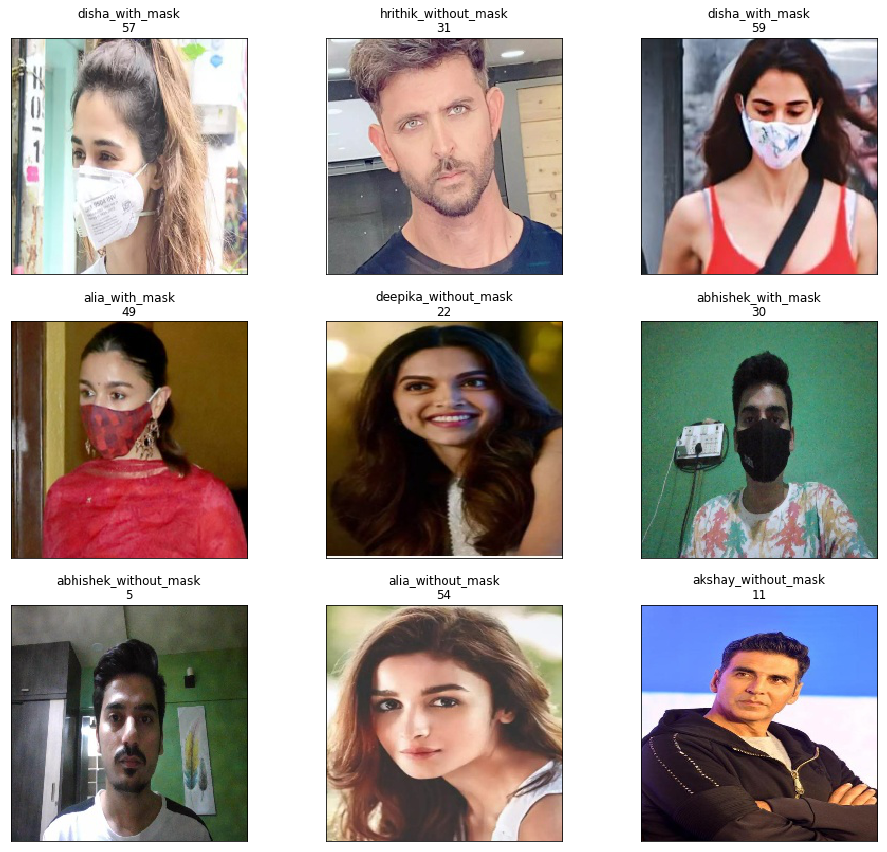

In [28]:
dlpy.images.ImageTable.from_table(sess.CASTable('processed_images')).show(nimages=9,ncol=3,id='_id_')

# Augment Images

In [29]:
temp = sess.CASTable('temp')
sess.image.augmentImages(
        casout={
            'name':temp
        },
        croplist=[
        {
            'sweepimage':True,
            'x':0,
            'y':0,
            'width':224,
            'height':224,
            'stepsize':250,
            'outputwidth':224,
            'outputheight':224,
            'mutations':{
                'verticalflip':False,
                'sharpen':True,
                'colorjittering':True,
                'rotateright':True,
                'invertpixels':True,
                'lighten':True,
                'pyramidup':True,
                'pyramiddown':True,
                'rotateleft':True,
                'colorshifting':True,
                'horizontalflip':True,
                'darken':True
                    }
        }
                ],
        table = {
            'name': 'processed_images'
        }
)

NOTE: The table PROCESSED_IMAGES contains encoded images.
NOTE: Out of 60 input images, 720 images were successfully produced and saved as encoded images to the Cloud Analytic Services table temp.


,casLib,Name,Rows,Columns,casTable
0,data,temp,720,7,"CASTable('temp', caslib='data')"


In [30]:
augment_images = sess.CASTable('augment_images')
sess.image.augmentImages(
        casout={
            'name':augment_images
        },
        croplist=[
        {
            'sweepimage':True,
            'x':0,
            'y':0,
            'width':224,
            'height':224,
            'stepsize':250,
            'outputwidth':224,
            'outputheight':224,
            'mutations':{
                'verticalflip':False,
                'sharpen':True,
                'colorjittering':True,
                'rotateright':True,
                'invertpixels':True,
                'lighten':True,
                'pyramidup':True,
                'pyramiddown':True,
                'rotateleft':True,
                'colorshifting':True,
                'horizontalflip':True,
                'darken':True
                    }
        }
                ],
        table = {
            'name': 'temp'
        }
)

NOTE: The table TEMP contains encoded images.
NOTE: Out of 720 input images, 8640 images were successfully produced and saved as encoded images to the Cloud Analytic Services table augment_images.


,casLib,Name,Rows,Columns,casTable
0,data,augment_images,8640,7,"CASTable('augment_images', caslib='data')"


In [31]:
# training_images.show(nimages=5, ncol=5, randomize=True)
sess.table.tableInfo(
        name='augment_images'
                    )

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,AUGMENT_IMAGES,8640,7,0,utf-8,2022-10-14T19:18:37+05:30,2022-10-14T19:18:37+05:30,2022-10-14T19:18:37+05:30,UTF8,1.981375e+09,...,0,0,0,,,0,abgujr,,,NaN


NOTE: The table AUGMENT_IMAGES contains encoded images.


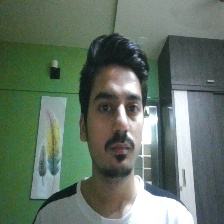

In [32]:
sess.image.fetchImages(imageTable = 'augment_images').Images.Image[10]

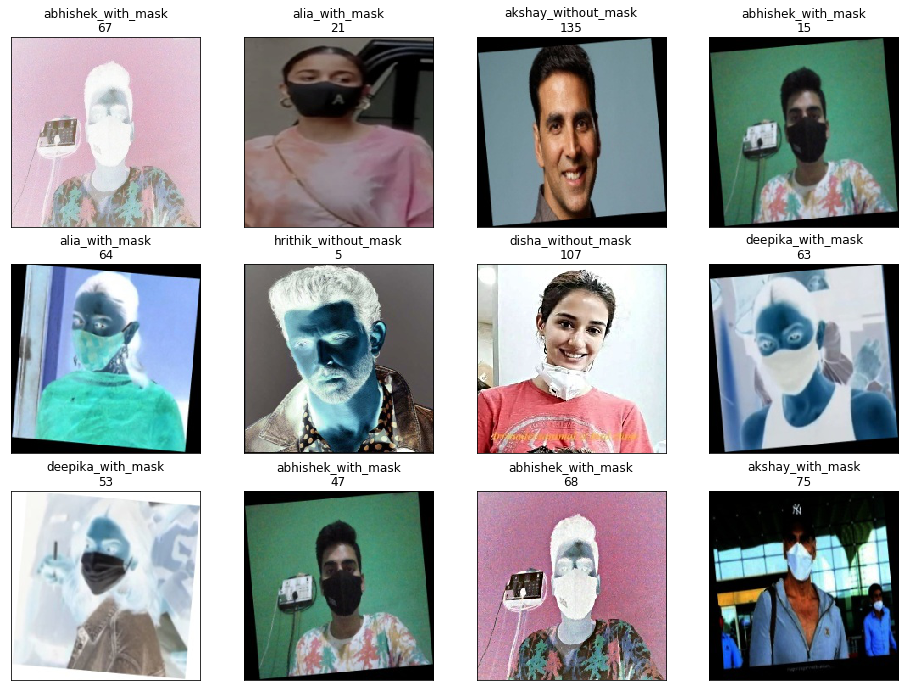

In [33]:
dlpy.images.ImageTable.from_table(sess.CASTable('augment_images')).show(nimages=12,ncol=4,id='_id_')

# Data Preparation

In [34]:
#split data into train and test
train, test = two_way_split(augment_images, test_rate = 20, stratify = True)

# Build Deep Learning Models

# Simple CNN Model

In [35]:
#Simple Convolutional Neural Network (CNN)
simple_model = Sequential(sess, model_table='simple_cnn')
simple_model.add(InputLayer(3, 224, 224, offsets = train.channel_means))
simple_model.add(Conv2d(n_filters = 8, width = 7, height = 7, stride = 1, act = 'relu'))
simple_model.add(Pooling(width = 2, height = 2, stride = 2))
simple_model.add(Conv2d(n_filters = 8, width = 7, height = 7, stride = 1, act = 'relu'))
simple_model.add(Pooling(width = 2, height = 2))
simple_model.add(Dense(n = 16, act = 'relu'))
simple_model.add(OutputLayer(act = 'Softmax', n = 12))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [36]:
#Preview the model Architecture
simple_model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,Convo.1,convo,"(7, 7)","(1, 1)",Relu,"(224, 224, 8)","(1176, 8)",59006976
2,2,Pool1,pool,"(2, 2)","(2, 2)",Max,"(112, 112, 8)","(0, 0)",0
3,3,Convo.2,convo,"(7, 7)","(1, 1)",Relu,"(112, 112, 8)","(3136, 8)",39337984
4,4,Pool2,pool,"(2, 2)","(2, 2)",Max,"(56, 56, 8)","(0, 0)",0
5,5,F.C.1,fc,"(25088, 16)",,Relu,16,"(401408, 0)",401408
6,6,Output1,output,,,Softmax,12,"(192, 12)",0
7,,,,,,,,Total number of parameters,Total FLOPS
8,Summary,,,,,,,"405,940","98,746,368"


# Epoch = 20

In [37]:
#Fit Simple_CNN deep learning model on GPU
simple_model.fit(data = train, max_epochs = 20,\
                lr = 0.001, gpu = dict(devices = [1]), n_threads = 1, log_level = 2)

NOTE: Inputs=_image_ is used
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 405956.
NOTE:  The approximate memory cost is 136.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.28 (s).
NOTE:  The total number of workers is 128.
NOTE:  The total number of threads on each worker is 1.
NOTE:  The maximum mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     12
NOTE:  Levels for the target variable:
NOTE:  Level      0: abhishek_with_mask   
NOTE:  Level      1: abhishek_without_mask
NOTE:  Level      2: akshay_with_mask     
NOTE:  Level      3: akshay_without_mask  
NOTE:  Level      4: alia_with_mask       
NOTE:  Level      5: alia_without_mask    
NOTE:  Level      6: deepika_with_mask    
NOTE:  Level      7: deepika_wi

,Descr,Value
0,Model Name,simple_cnn
1,Model Type,Convolutional Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1
8,Number of Weight Parameters,405912
9,Number of Bias Parameters,44


In [38]:
simple_model.training_history

,Epoch,LearningRate,Loss,FitError
0,1,0.001,3.361017,0.897135
1,2,0.001,2.442870,0.873264
2,3,0.001,2.349892,0.821325
3,4,0.001,2.125196,0.716869
4,5,0.001,1.781582,0.599971
5,6,0.001,1.526784,0.514468
6,7,0.001,1.250069,0.410880
7,8,0.001,1.071868,0.354601
8,9,0.001,0.892867,0.302083
9,10,0.001,0.752182,0.245804


# Score test data using simple model

In [39]:
simple_model.predict(test, gpu = dict(devices = [1]))

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1728
 1  Number of Observations Used          1728
 2  Misclassification Error (%)      13.94676
 3                   Loss Error      0.612842

[OutputCasTables]

   casLib              Name  Rows  Columns                                     casTable
 0   data  Valid_Res_BSAa8x  1728       19  CASTable('Valid_Res_BSAa8x', caslib='data')

+ Elapsed: 3.23s, user: 107s, sys: 103s, mem: 1.5e+05mb

# Verify Model Training

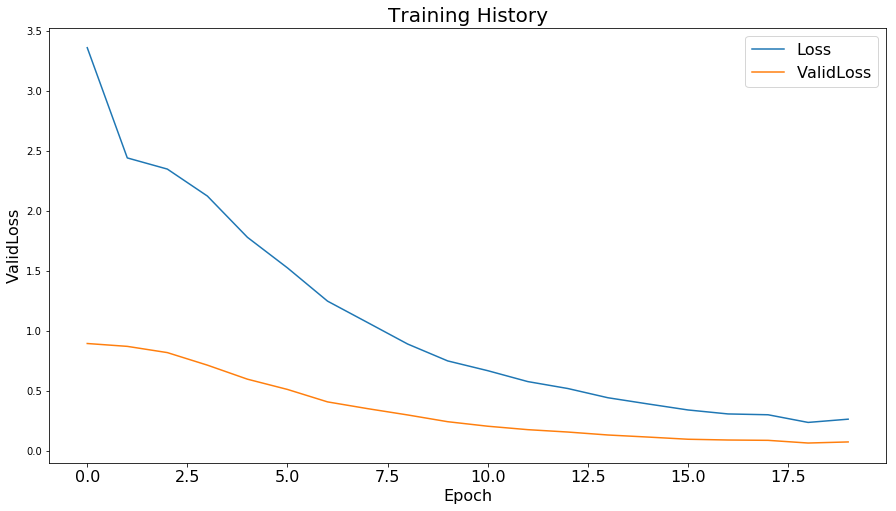

In [41]:
plt.figure(figsize = (15,8))
plt.plot(simple_model.training_history.tail(100)[['Loss','FitError']])
plt.ylabel('ValidLoss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.xticks(fontsize=16)
plt.title('Training History', fontsize=20)
plt.legend(['Loss','ValidLoss'], fontsize=16)
plt.show()